<a href="https://colab.research.google.com/github/saffarizadeh/INSY4054/blob/main/Web_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://saffarizadeh.com/Logo.png" width="300px"/>

# *INSY 4054: Emerging Technologies*

# **Web Scraping**

Instructor: Dr. Kambiz Saffarizadeh

---

# Accessing Page Elements

We typically want to extract some specific information from a page after dowloading it. We have many different ways to approach this problem. The common ways are XPath, BeautifulSoup, and Regular Expressions. Here we have two simple examples of using XPath and BeautifulSoup.

## Using BeautifulSoup
 
Learn more about BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

BeautifulSoup is typically considered to be much simpler that XPath. While with XPath you can achieve a lot by just writing a short line of code, writing that line of code is often very challenging if you don't understand XPath rules well. But with BeautifulSoup your code is typically longer but much more Pytonic (therefore, much easier to understand and modify).

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
url = 'https://www.marquette.edu/'
response = requests.get(url)

In [ ]:
soup = BeautifulSoup(response.content, 'lxml')

In [ ]:
all_links = soup.find_all('a')
all_links

Get the text inside an element

In [ ]:
link_labels = []
for link in all_links:
  link_labels.append(link.text)

In [ ]:
link_labels

Get an attribute inside an element

In [ ]:
link_urls = []
for link in all_links:
  link_urls.append(link.get('href'))

In [ ]:
link_urls

Combine links and labels using zip (for more information see: https://docs.python.org/3/library/functions.html#zip)

In [ ]:
label_url_pairs = list(zip(link_labels, link_urls))

In [ ]:
label_url_pairs

In [ ]:
# Cleaning based on whether the url starts with 'http'
cleaned_label_url_pairs = []

for label, url in label_url_pairs:
    if url[:4] == "http":
        cleaned_label_url_pairs.append((label, url))

In [ ]:
cleaned_label_url_pairs

In [ ]:
# Cleaning based on adding the proper https:// to the URLs without http

BASE_URL = "https://www.marquette.edu"

cleaned_label_url_pairs2 = [requests.compat.urljoin(BASE_URL, url) for url in link_urls]

In [ ]:
cleaned_label_url_pairs2

## Download all images

In [ ]:
# With BeautifulSoup
image_urls = [image.get('src') for image in soup.find_all('img')]
image_urls

Some images have a full URL but many don't. Even worse, some of the ones that don't have a full URL start with a `/` and some don't.

Fortunately, we can fix this problem with little effort using the `urljoin` method from `requests.compat`.

In [ ]:
BASE_URL = "https://www.marquette.edu"

fixed_image_urls = [requests.compat.urljoin(BASE_URL, image_url) for image_url in image_urls]

In [ ]:
fixed_image_urls

## How can we leverage alt text of the images as possible labels for supervised machine learning 

In [ ]:
# With BeautifulSoup
image_alts = [img.get('alt') for img in soup.find_all('img')]
image_alts

In [ ]:
image_alt_pairs = list(zip(fixed_image_urls, image_alts))

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(image_alt_pairs, columns={"image_url", "image_alt"})
df

## Download Images

To dowload all images, we first need to create a directory to keep the downloaded images. To do so, we use the `os` library, which gives us the needed tools to, among other things, create directories and manipulate the file paths in a way that is compatible with our operating system.

In [ ]:
import os

In [ ]:
directory = "images"
os.makedirs(directory, exist_ok=True) # With exist_ok=True, we will not get an error if the directory already exists

Go through image urls and download them one by one.

Use a unique id starting from 0 as file name to avoid duplicate names.

In [ ]:
image_counter = 0
for url in fixed_image_urls:
  image_extension = url.split(".")[-1]                      # Split the url based on the dots in the string and grab the last part which basically shows the extension of the file
  image_name = str(image_counter) + "." + image_extension   # Create an name with the proper extension to be used when we save the image
  image_address = os.path.join(directory, image_name)       # Add the folder name to the image name
  image_response = requests.get(url)
  if image_response.status_code == 200:
    with open(image_address, "wb") as f:                    # This is how we can save a file with a specific name to save the downloaded image
      f.write(image_response.content)
  image_counter = image_counter + 1

## Modifying images with TensorFlow

https://www.tensorflow.org/api_docs/python/tf/image

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

It is possible to use some tensorflow tools to directly load all images.

It is also possible to read/write and modify the images using other libraries such as `imageio` and Pillow (`PLT`).

But here we see how to do this manually using `tensorflow` to have more control over the process and preprocess the images the way we want. Furthermore, this can add to our growing knowledge of `tensorflow`.

In [ ]:
image_names = []
images_list = []
# We use the following nested loops to get all files inside a directory, one by one
for subdir, dirs, files in os.walk(os.path.join(os.getcwd(), directory)):
  for filename in sorted(files):
    filename = filename.lower()
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
      image_path = os.path.join(subdir, filename)
      image_d = tf.keras.preprocessing.image.load_img(image_path)
      image_array = tf.keras.preprocessing.image.img_to_array(image_d) / 255.0
      image_array = tf.image.resize_with_pad(image_array, 299,299, antialias=True)
      images_list.append(image_array)
      image_names.append(filename)
image_arrays = np.array(images_list)

In [ ]:
image_arrays.shape

(29, 299, 299, 3)

We load the Inception V3 model from TensorFlow Hub. We add a Softmax layer to the end of the model to make sure the model gives us probabilities instead of apparently meaningless numbers (logits).

In [ ]:
inception_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4", output_shape=[1001]),
    tf.keras.layers.Softmax()
])
inception_model.build([None, 299, 299, 3])  # Batch input shape.

We can pass all image arrays direcly to the model and get all predications at once.

In [ ]:
output = inception_model(image_arrays)

The model gives is 25 predictions:

In [ ]:
output.shape

TensorShape([29, 1001])

To make sense of these predications, we need to have the class names:

In [ ]:
# This is could be done in a single line, but here we expand it for readability
classes_response = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
classes_text = classes_response.text
classes = classes_text.split('\n')

Now, we can check how well the model performed

In [ ]:
num = 14

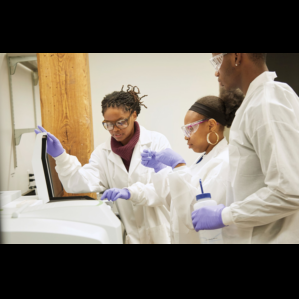

In [ ]:
# Show an image from the image_arrays
tf.keras.preprocessing.image.array_to_img(image_arrays[num])

Get top 5 classes and their probabilities.

To do so, we use the `argsort` method of `numpy` to sort the result of this specific predictation. Since `argsort` sorts the numbers in ascending order, we multiply the result by -1 to make them negative so that the largest number becomes the smallest number (most negative number). This way the ascending order really represents a descending order.

`np.argsort` gives us the indecies of the values in `result` sorted in descending order. We convert these indecies into a list and loop through them. In each iteration of the loop we grap the index and use it to extract the acual value associated with this index from the `result`. Because of the `Softmax` layer in our model, the values in `result` are between 0 and 1, representing probabilities. So, we can multiply them by 100 and round them using 2 decimal points to make them more readbale.

We can also use the index in each interation to extract the class name from the `classes` list we downloaded earlier.

In [ ]:
result = output[num]
top_labels = [(classes[index], round(result[index].numpy()*100, 2)) for index in list(np.argsort(-1*result))]
print(top_labels[:5])

[('lab coat', 89.38), ('web site', 1.85), ('stethoscope', 1.15), ('monitor', 0.64), ('television', 0.53)]


To create a table with image name, label, and the model's confidence in the accuracy of the label, we can go through all images and create a list of labels and confidences. Next, we can put these lists together in a `pandas.DataFrame`.

In [ ]:
labels = []
confidences = []
for i in range(len(image_names)):
  result = output[i]
  max_index = np.argmax(result)
  label = classes[max_index]
  confidence = result[max_index].numpy()
  labels.append(label)
  confidences.append(confidence)

Put everything in a `DataFrame`.

In [ ]:
df_final = pd.DataFrame({"image": image_names, "label": labels, "confidence": confidences})
df_final

,image,label,confidence
0,1.jpg,car mirror,0.194479
1,10.jpg,ping-pong ball,0.281152
2,11.jpg,restaurant,0.302634
3,12.jpg,monitor,0.694435
4,13.jpg,groom,0.786518
5,14.jpg,television,0.478036
6,15.jpg,groom,0.566393
7,16.jpg,basketball,0.904597
8,17.jpg,French horn,0.150405
9,18.png,rule,0.917271


Finally, we export the results into an Excel file.

In [ ]:
df_final.to_excel("classified_images.xlsx")